# Define the system  

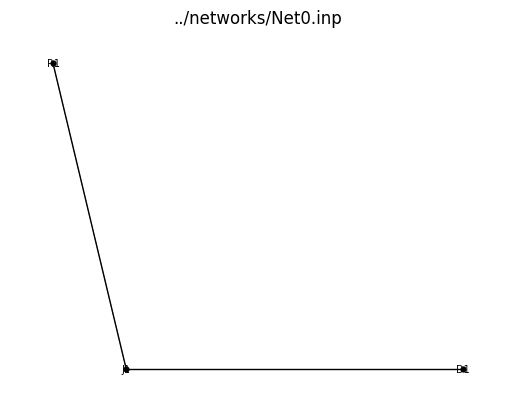

<Axes: title={'center': '../networks/Net0.inp'}>

In [1]:
import wntr
import wntr_quantum
import numpy as np

# Create a water network model
inp_file = '../networks/Net0.inp'
# inp_file = '../networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original Cholesky EPANET simulator

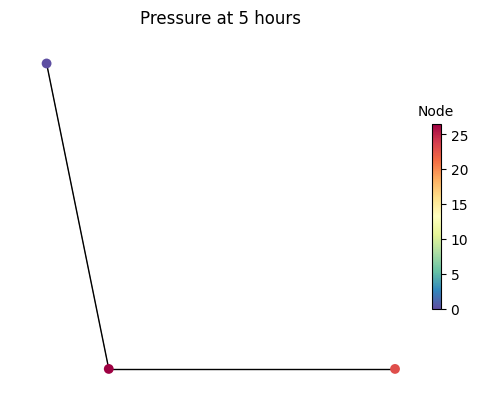

<Axes: title={'center': 'Pressure at 5 hours'}>

In [2]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [3]:
ref_pressure = results.node['pressure'].values[0][:2]
ref_pressure

array([26.477, 22.954], dtype=float32)

In [4]:
ref_rate = results.link['flowrate'].values[0]
ref_rate

array([0.05, 0.05], dtype=float32)

In [5]:
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 0.05 ,  0.05 , 26.477, 22.954], dtype=float32)

## Run with the Nework QUBO solver

In [17]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [18]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubols.solution_vector import SolutionVector_V2 as SolutionVector
from qubols.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 9
step = (0.5/(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+1.5, var_base_name="x")

nqbit = 9
step = (50/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+50.0, var_base_name="x")

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 50.000000 => 100.000000 (res: 0.097847)
Flow Encoding : 1.500000 => 2.000000 (res: 0.000978)


Solve the system classically

In [19]:
from wntr_quantum.sim.hydraulics import create_hydraulic_model
model, model_updater = create_hydraulic_model(wn)
net.matrices = net.initialize_matrices(model)

ref_sol = net.classical_solutions()
ref_sol / ref_values

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


array([1.   , 1.   , 0.999, 0.998])

In [20]:
from qubols.mixed_solution_vector import MixedSolutionVector_V2 as MixedSolutionVector
from qubols.qubo_poly_mixed_variables import QUBO_POLY_MIXED
from qubols.solution_vector import SolutionVector_V2 as SolutionVector
import sparse

from dwave.samplers import SimulatedAnnealingSampler
from dwave.samplers import SteepestDescentSolver
from dwave.samplers import TabuSampler
from dimod import ExactSolver

from wntr_quantum.sim.hydraulics import create_hydraulic_model

sampler = TabuSampler()
sampler = SteepestDescentSolver()
# sampler = SimulatedAnnealingSampler()
# sampler = ExactSolver() 

model, model_updater = create_hydraulic_model(wn)
net.matrices = net.initialize_matrices(model)

qubo = QUBO_POLY_MIXED(net.mixed_solution_vector,  options={"sampler" : sampler} )
matrices = tuple(sparse.COO(m) for m in net.matrices)
bqm = qubo.create_bqm(matrices, strength=1E6)
sampleset = qubo.sample_bqm(bqm, num_reads=10000)
sol = qubo.decode_solution(sampleset.lowest().record[0][0])
sol = net.flatten_solution_vector(sol)


In [21]:
sol = net.convert_solution_to_si(sol)

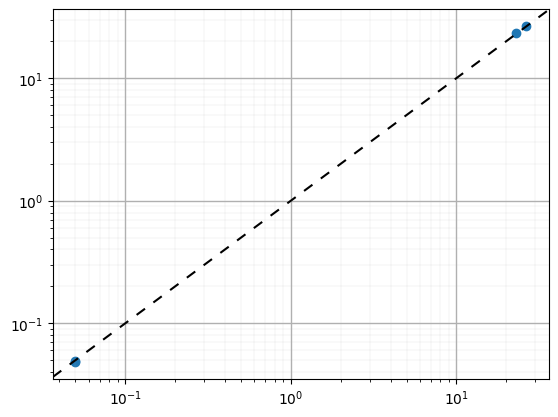

In [22]:
net.plot_solution_vs_reference(sol, ref_sol)

In [23]:
net.benchmark_solution(sol, ref_sol, qubo, bqm)

Head Encoding : 50.000000 => 100.000000 (res: 0.097847)
Flow Encoding : 1.500000 => 2.000000 (res: 0.000978)


Error (%): [ 3.135  1.14  -0.895 -1.404]


sol :  [ 1.71   1.746 87.573 76.223]
ref :  [ 1.766  1.766 86.797 75.168]
diff:  [ 0.055  0.02  -0.777 -1.055]


encoded_sol:  [ 1.71   1.746 87.573 76.223]
encoded_ref:  [ 1.766  1.766 86.791 75.147]
diff       :  [ 0.056  0.021 -0.783 -1.076]


E sol   :  -1662.5932732365866
R ref   :  -1662.6061020456154
Delta E : 0.012828809028860633


Residue sol   :  0.11372143432826409
Residue ref   :  0.010186471203764017
Delta Residue : 0.10353496312450007


In [24]:
net.solve(model, strength=1E6, num_reads=1000, options={"sampler" : sampler})
model.get_x()

array([ 0.05 ,  0.05 , 26.394, 22.845])

In [25]:
net.benchmark_solution(model.get_x(), ref_sol, qubo, bqm)

Head Encoding : 50.000000 => 100.000000 (res: 0.097847)
Flow Encoding : 1.500000 => 2.000000 (res: 0.000978)


Error (%): [-0.633 -0.079  0.232  0.289]


sol :  [ 1.777  1.767 86.595 74.951]
ref :  [ 1.766  1.766 86.797 75.168]
diff:  [-0.011 -0.001  0.202  0.217]


encoded_sol:  [ 1.777  1.767 86.595 74.951]
encoded_ref:  [ 1.766  1.766 86.791 75.147]
diff       :  [-0.011 -0.001  0.196  0.196]


E sol   :  -1662.602117970269
R ref   :  -1662.6061020456154
Delta E : 0.003984075346352256


Residue sol   :  0.06393622613853261
Residue ref   :  0.010186471203764017
Delta Residue : 0.0537497549347686


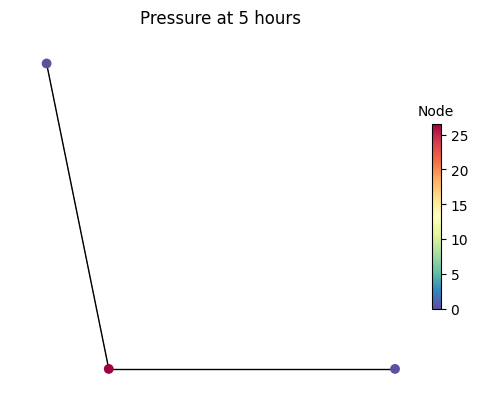

<Axes: title={'center': 'Pressure at 5 hours'}>

In [26]:
sim = wntr_quantum.sim.FullQuboPolynomialSimulator(wn, 
                                                   flow_encoding=flow_encoding, 
                                                   head_encoding=head_encoding)
results = sim.run_sim(solver_options={"sampler" : sampler})

# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [27]:
results.node['pressure']

,J1,D1,R1
0,26.543249,0.047435,0.0
3600,26.722192,0.050095,0.0


In [28]:
results.link['flowrate']

,P1,P2
0,23.322270,0.049319
3600,23.173151,0.047961
